In [42]:
import argparse
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

#parser = argparse.ArgumentParser(description="Calculates accuracy of centroid models.")
#parser.add_argument('label_input', help='CSV file containing true centroid values. This can be made from converting research XML files from LABEL_PARTY folder using research_centroids.py')
#parser.add_argument('test_input', help='CSV file to test, formatted with labels /"#, frame, x, y/"')
#args = parser.parse_args()
#label_df = pd.read_csv(args.label_input)
#test_df = pd.read_csv(args.test_input)

LABEL_DF = pd.read_csv('./../research_data/input_mp4.csv') #Ground Truth Data
TEST_DF = pd.read_csv('./../data/4_22_2020_mask.mp4_blobdetector.csv') #Points we are testing
#delete above two lines and replace with commented code when finished

#sorting the data by the video frame, 1st frame, 2nd, 3rd, etc.
label_df = LABEL_DF.sort_values('frame')
test_df = TEST_DF.sort_values('frame')
#cleaning data, removing unnecessary columns & relabeling
del test_df['Unnamed: 0']
del label_df['velocity']
del label_df['baboon id']
label_df = label_df.rename(columns={"centroid_x": "x", "centroid_y": "y"})

In [43]:

all_frames = label_df['frame'].unique() #list of frames where there are baboons

#Initialize k-d tree
nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree')

#Cycles through every frame that we have Ground Truth data in
alldist = ([[0]])
for frame in all_frames:
    fill_set = label_df.loc[label_df['frame'] == frame] #grabs all baboons identified in that frame from Ground Truth data
    del fill_set['frame']
    nbrs.fit(fill_set.to_numpy()) #fill k-d tree with all Ground Truth positions of baboons in that frame
    
    find_set = test_df.loc[test_df['frame'] == frame] #grabs baboon positions for this frame from test data
    del find_set['frame']
    find_num = find_set.to_numpy()#convert to npy / req. to pass to kneighbors
    if find_num.size == 0: #edge case
        continue
    distances, indices = nbrs.kneighbors(find_num)
    alldist = np.concatenate((alldist, distances))
print("Finished collecting distances.")
print(alldist)


Finished collecting distances.
[[  0.        ]
 [  3.14059627]
 [  7.90323505]
 ...
 [  6.26311778]
 [158.97024653]
 [ 17.10077865]]


In [44]:
#Plot the Euclidian distance data on a histogram
def map_histo(data, range_min, range_max, bins, rwidth = 0.2):
    range = (range_min, range_max)
    print("Range:", range)
    plt.hist(data, bins, range, color = 'green', histtype = 'bar', rwidth = rwidth)
    plt.xlabel('Pixels from Ground Truth') 
    plt.ylabel('No. of centriods') 
    plt.title('Euclidean Distance') 
    plt.show() 

Range: (0, 1785)


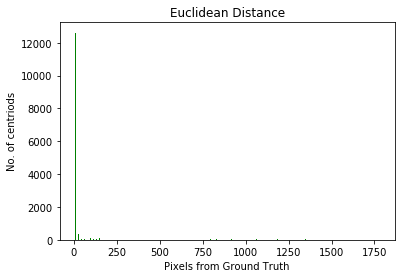

In [45]:
map_histo(alldist, int(min(alldist)), int(max(alldist)), 100)

Range: (0, 250)


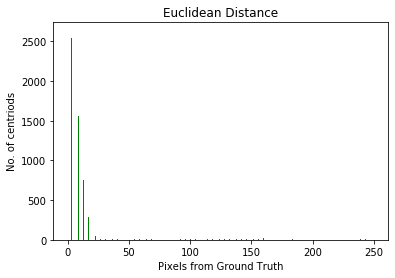

In [46]:
map_histo(alldist, 0, 250, 126)

Range: (0, 50)


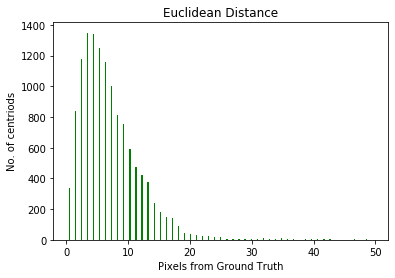

In [47]:
map_histo(alldist, 0, 50, 51)

Range: (0, 30)


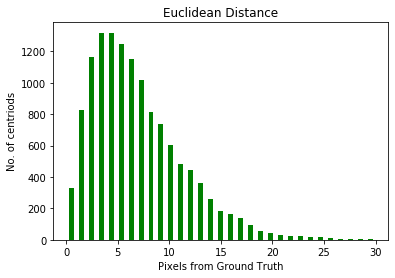

In [48]:
map_histo(alldist, 0, 30, 31, 0.5)

In [49]:
#Use Z-score to identify outliers
#Z score = (Observation — Mean)/Standard Deviation


def remove_outliers(data, standard_deviations=3):
    keepers=[]
    threshold=standard_deviations #number of standard deviations above mean
    mean = np.mean(data)
    print("REMOVING OUTLIERS")
    print("Mean: ", mean)
    std =np.std(data)
    print("Standard Deviation: ", std)
    
    for y in data:
        z_score= (y - mean)/std
        if np.abs(z_score) <= threshold:
            keepers.append(y)
    print("Before removal: ", len(data))
    print("After removal: ", len(keepers))
    print( (1-(len(keepers)/len(data))) * 100, "% lost in removal.")
    return keepers
clean_datapoints = remove_outliers(alldist[:,0].tolist(), 1)

REMOVING OUTLIERS
Mean:  70.7033221872042
Standard Deviation:  247.23091964721357
Before removal:  14382
After removal:  13534
5.8962592129050195 % lost in removal.


In [50]:
clean_datapoints2 = remove_outliers(clean_datapoints)

REMOVING OUTLIERS
Mean:  12.351652391737518
Standard Deviation:  28.008506438382852
Before removal:  13534
After removal:  13103
3.1845721885621403 % lost in removal.


In [51]:
print( (1-(len(clean_datapoints2)/alldist.shape[0])) * 100, "% lost in total.")

8.893060770407457 % lost in total.


In [52]:
print("Trimming to distances < 25")
trim = alldist[alldist < 25]
print((len(trim)/len(alldist))*100, "%")

Trimming to distances < 25
89.4659991656237 %


In [53]:
_ = remove_outliers(trim)

REMOVING OUTLIERS
Mean:  6.858209012934718
Standard Deviation:  4.341422307670411
Before removal:  12867
After removal:  12737
1.0103365197792757 % lost in removal.


In [54]:
#How many baboons does it predict out of all frames and all baboons?
print("Total number of instances of baboons in Ground Truth data(Every baboon identified in every frame of the video, summed):")
print(label_df.shape[0])
print("Total number of instances of baboons identified by data set to 25 pixels:")
print(len(trim))
print(len(trim)/label_df.shape[0]*100)

Total number of instances of baboons in Ground Truth data(Every baboon identified in every frame of the video, summed):
124894
Total number of instances of baboons identified by data set to 25 pixels:
12867
10.302336381251301
